# Advances in agrogeophysics
DOI: TODO

This notebook contains the code to reproduce the figures from the manuscript from the processed data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
from matplotlib.colors import ListedColormap
import matplotlib as mpl
from scipy import stats
import seaborn as sns
from tqdm import tqdm

datadir = '../data/'
figdir = datadir + '../figures/'

colors = (
    plt.get_cmap('Blues', 10)(7), plt.get_cmap('Blues', 10)(5), plt.get_cmap('Blues', 10)(3),
    plt.get_cmap('Oranges', 10)(7), plt.get_cmap('Oranges', 10)(5), plt.get_cmap('Oranges', 10)(3),
    plt.get_cmap('Greens', 10)(7), plt.get_cmap('Greens', 10)(5), plt.get_cmap('Greens', 10)(3),
)
cmap = ListedColormap(colors)
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=cmap.colors)
letters = 'abcdefghijklmnopqrstuvwxyz'

In [2]:
# loading datasets
dfobs = pd.read_csv(datadir + 'processed/dfobs.zip', parse_dates=['time'])
dfweather = pd.read_csv(datadir + 'processed/dfweather.csv', parse_dates=['time'])
dfmeteo = pd.read_csv(datadir + 'processed/dfmeteo.csv', parse_dates=['time'])
dfsal = pd.read_csv(datadir + 'processed/dfsal.csv', parse_dates=['time'])
dfditch = pd.read_csv(datadir + 'processed/dfditch.csv', parse_dates=['time'])
dfec1_5 = pd.read_csv(datadir + 'processed/dfec1_5.csv', parse_dates=['time'])
dfeca = pd.read_csv(datadir + 'processed/dfeca.csv', parse_dates=['time'])
dfdrain = pd.read_csv(datadir + 'processed/dfdrain.csv', parse_dates=['time'])
dfvwc = pd.read_csv(datadir + 'processed/dfvwc.zip', parse_dates=['time'])
dfec2 = pd.read_csv(datadir + 'processed/dfec2.csv', parse_dates=['time'])
dfec = pd.read_csv(datadir + 'processed/dfec.csv', parse_dates=['time'])
dfsoil = pd.read_csv(datadir + 'processed/dfsoil.csv')
dfcrop = pd.read_csv(datadir + 'processed/dfcrop.csv', parse_dates=['time'])
dfhead = pd.read_csv(datadir + 'processed/dfhead.csv', parse_dates=['time'])
dflevel = pd.read_csv(datadir + 'processed/dflevel.csv', parse_dates=['time'])
dfthresh = pd.read_csv(datadir + 'processed/dfthresh-eca.csv', parse_dates=['time'])
dfndvi = pd.read_csv(datadir + 'processed/dfndvi.csv', parse_dates=['time'])

/tmp/ipykernel_95685/3018899601.py:2: DtypeWarning: Columns (9,10,37) have mixed types. Specify dtype option on import or set low_memory=False.
  dfobs = pd.read_csv(datadir + 'processed/dfobs.zip', parse_dates=['time'])


In [3]:
# useful functions
def addGap(x, y, Z, pad=1, dt=None):
    # add datagap and edges for pcolormesh
    Z = np.array(Z, dtype=float)
    xdiff = np.diff(x)
    if dt is None:
        dt = np.median(xdiff)
    igap = np.where(xdiff > dt + np.timedelta64(pad, 'h'))[0]
    nan = np.ones((Z.shape[0], len(igap)))*np.nan
    x2 = np.r_[x[0] - np.timedelta64(dt/2, 'h'), x + np.timedelta64(dt/2, 'h')]
    xgap = x2[igap+2] - np.timedelta64(dt/2, 'h')
    x2 = np.sort(np.r_[x2, xgap])
    if len(y) == Z.shape[0]+1:
        y2 = y
    else:
        y2 = np.r_[y[0] - (y[1] - y[0])/2, y[:-1] + np.diff(y)/2, y[-1] + (y[-2]-y[-1])/2]
    Z2 = np.insert(Z, igap+1, nan, axis=1)
    X2, Y2 = np.meshgrid(x2, y2)
    return X2, Y2, Z2
    
def mergeManualAuto(xm, ym, xserie, yserie):
    # removing any nan in the serie
    inan = ~np.isnan(ym)
    xm = xm[inan]
    ym = ym[inan]
    inan = ~np.isnan(yserie)
    xserie = xserie[inan]
    yserie = yserie[inan]

    # exclude manual reading taken during the sensor serie for merging
    if len(xm) > 0:
        dist = np.abs(xm[:, None] - xserie[None, :])
        iduring = np.min(dist, axis=0) > np.timedelta64(1, 'D')#86400000000000  # 1 day in nanoseconds
    else:
        iduring = np.ones(iem.sum(), dtype=bool)

    # merge manual and sensor serie
    x = np.r_[xm, xserie[iduring]]
    y = np.r_[ym, yserie[iduring]]
    isort = np.argsort(x)

    return x[isort], y[isort]

## Interactive data overview
With Bokeh figure.

In [4]:
from bokeh.plotting import show, save, figure, output_notebook, output_file
from bokeh.layouts import row, column
from bokeh.models import DatetimeTickFormatter, Legend, CheckboxGroup, CustomJS

#output_notebook()
output_file(figdir + 'overview.html', title='GeophySal overview')

In [5]:
# (bokeh) interactive data overview
pdic = {}

# weather data
p = figure(width=800, height=100, x_axis_type='datetime')
p.y_range.flipped = True
p.step(dfweather['time'], dfweather['PRECIP_QUANTITY'], color='blue')
p.yaxis.axis_label = 'Rain\n[mm/day]'
p.xaxis.formatter=DatetimeTickFormatter(days='%Y-%m-%d', months='%Y-%m')
pdic['weather'] = p

# psmd
p = figure(width=800, height=100, x_axis_type='datetime', x_range=pdic['weather'].x_range)
p.line(dfweather['time'], dfweather['psmd'], color='red')
p.yaxis.axis_label = 'PSMD [mm]'
p.xaxis.formatter=DatetimeTickFormatter(days='%Y-%m-%d', months='%Y-%m')
pdic['psmd'] = p


# crops
p = figure(width=800, height=100, x_axis_type='datetime', x_range=pdic['weather'].x_range)
cropdic = {
    'Flax': 'orange',
    'Winter flax': 'orange',
    'Winter wheat': 'green',
    'Grass': 'lightgreen',
    'Winter wheat + beans': 'lightgreen',
    'Triticale + Beans': 'purple',
}
for linestyle, name, label in zip(['--', '-'], ['CD2', 'RD2'], ['CD & ND', 'RD']):
    ie = dfndvi['field'].eq(name[:2].lower())
    df1 = dfndvi[ie][['time', 'median']].copy()
    shdates = dfcrop[dfcrop['name'].eq(name) 
                & dfcrop['event'].isin(['sowing', 'harvest'])]['time'].values
    df2 = pd.DataFrame({'time': shdates})
    df = pd.concat([df1, df2]).sort_values('time').interpolate()
    ie = dfcrop['name'].eq(name)
    sdf = dfcrop[ie].copy().reset_index(drop=True)
    for j in range(sdf.shape[0]):
        if sdf.loc[j, 'event'] == 'sowing':
            sowingDate = sdf.loc[j, 'time']
        elif sdf.loc[j, 'event'] == 'harvest':
            harvestDate = sdf.loc[j, 'time']    
            icrop = df['time'].gt(sowingDate) & df['time'].le(harvestDate)
            line_dash = 'solid' if linestyle == '-' else 'dashed'
            p.line(df[icrop]['time'], df[icrop]['median'],
                            color=cropdic[sdf.loc[j, 'crop']], line_dash=line_dash)
p.yaxis.axis_label = 'NDVI [-]'
p.xaxis.formatter=DatetimeTickFormatter(days='%Y-%m-%d', months='%Y-%m')
pdic['ndvi'] = p


cdic = {
    'CD1': 'darkblue',
    'CD2': 'blue',
    'CD3': 'lightblue',
    'RD1': 'darkred',
    'RD2': 'red',
    'RD3': 'orange',
    'ND1': 'darkgreen',
    'ND2': 'green',
    'ND3': 'lightgreen',
    'ditchCD': 'lightgrey',
    'ditchRD': 'darkgrey',
}


# add drainage level
p = figure(width=800, height=100, x_axis_type='datetime', x_range=pdic['weather'].x_range)
for field in dflevel['field'].unique():
    ie = dflevel['field'].eq(field)
    p.line(dflevel[ie]['time'], dflevel[ie]['outlet_mTAW'],
            color=cdic[field + '1'])
p.yaxis.axis_label = 'Drain level\n[mTAW]'
p.xaxis.formatter=DatetimeTickFormatter(days='%Y-%m-%d', months='%Y-%m')
pdic['level'] = p 

# drainage
p = figure(width=800, height=100, x_axis_type='datetime', x_range=pdic['weather'].x_range)
areadic = {
    'CD': 30000,
    'RD': 18000,
    'ND': 3875,
}
periods = [pd.to_datetime('2022-01-01'), pd.to_datetime('2023-01-01'),
           pd.to_datetime('2024-02-16'), pd.to_datetime('2025-01-01')]

for i, name in enumerate(areadic.keys()):
    ie = dfdrain['name'].eq(name) & dfdrain['time'].gt(pd.to_datetime('2023-06-01'))
    df = dfdrain[ie].copy()
    df['dt'] = df['time'].diff().dt.seconds/3600  # fractional hours
    df['q'] = df['Debiet'] * df['dt']  # we have m3 or the time between two readings
    df['q_mm'] = df['q'] / areadic[name] * 1000  # mm for the time betwee readings
    df = df.set_index('time').resample('D').sum().reset_index()
    for j in range(len(periods) - 1):
        ie = df['time'].between(periods[j], periods[j+1])
        p.line(df[ie]['time'], df[ie]['q_mm'].cumsum(), color=cdic[name + '1'])
p.yaxis.axis_label = 'Cum. discharge\n[mm]'
p.xaxis.formatter=DatetimeTickFormatter(days='%Y-%m-%d', months='%Y-%m')
pdic['drainage'] = p

# soil moisture
p = figure(width=800, height=120, x_axis_type='datetime', x_range=pdic['weather'].x_range)
lvwcs = {}
for i, name in enumerate(cdic):
    ie = dfvwc['name'].eq(name) & dfvwc['depth'].eq(0.3)
    c = p.line(dfvwc[ie]['time'], dfvwc[ie]['vwc'],
           color=cdic[name])
    lvwcs[name] = c
p.yaxis.axis_label = 'VWC [v/v]\nat 0.3 m'
p.xaxis.formatter=DatetimeTickFormatter(days='%Y-%m-%d', months='%Y-%m')
pdic['moisture'] = p

# merge them all in a large df
dfmanual = pd.merge(dfhead, dfec, on=['time','location','name'], how='outer')
dfmanual = dfmanual.rename(columns={
    'EC_uS.cm-1': 'electrical_conductivity',
    'head_fresh_mTAW': 'head_fresh_mtaw',
})
# dfmanual = dfmanual.dropna(subset=['electrical_conductivity'])
dfmanual = dfmanual[dfmanual['time'].lt(pd.to_datetime('2022-11-01'))]
ie = dfobs['time'].gt(pd.to_datetime('2022-11-01'))
df = pd.concat([dfmanual, dfobs[ie], dfditch], axis=0).reset_index(drop=True)

# water table (mTAW)
p = figure(width=800, height=120, x_axis_type='datetime', x_range=pdic['weather'].x_range)
lwts = {}
for i, name in enumerate(cdic):
    val = name if 'ditch' in name else name + '-300'
    ie = df['name'].eq(val)
    c = p.line(df[ie]['time'], df[ie]['head_fresh_mtaw'],
           color=cdic[name])
    lwts[name] = c

# p.line([
#     pd.to_datetime('2022-12-02'), pd.to_datetime('2023-03-08'),
#     pd.to_datetime('2023-03-08'), pd.to_datetime('2023-12-20'),
#     pd.to_datetime('2023-12-20'), pd.to_datetime('2024-01-25'),
#     pd.to_datetime('2024-01-25'), pd.to_datetime('2024-06-01'),
# ],[2.33, 2.33, 2.43, 2.43, 2.28, 2.28, 2.43, 2.43], color='black')

p.yaxis.axis_label = 'Head fresh\n[mTAW]'
p.xaxis.formatter=DatetimeTickFormatter(days='%Y-%m-%d', months='%Y-%m')
pdic['head'] = p

# EC
p = figure(width=800, height=120, x_axis_type='datetime', x_range=pdic['weather'].x_range)
lecs = {}
for i, name in enumerate(cdic):
    val = name if 'ditch' in name else name + '-300'
    ie = df['name'].eq(val)
    c = p.line(df[ie]['time'], df[ie]['electrical_conductivity'],
           color=cdic[name])
    lecs[name] = c

p.yaxis.axis_label = 'EC [uS/cm]'
p.xaxis.formatter=DatetimeTickFormatter(days='%Y-%m-%d', months='%Y-%m')
pdic['ec_w'] = p

# Na+ manual measurements
p = figure(width=800, height=100, x_axis_type='datetime', x_range=pdic['weather'].x_range)
lnas = {}
labels = []
for i, name in enumerate(cdic):
    val = name if 'ditch' in name else name + '-300'
    ie = dfsal['name'].eq(val)
    c = p.line(dfsal[ie]['time'], dfsal[ie]['salinity_ppm'],
           color=cdic[name])
    lnas[name] = c
    labels.append((name, [c]))

p.yaxis.axis_label = 'Na+ [ppm]'
p.xaxis.formatter=DatetimeTickFormatter(days='%Y-%m-%d', months='%Y-%m')
pdic['na+'] = p

# threshold from ECa
p = figure(width=800, height=150, x_axis_type='datetime', x_range=pdic['weather'].x_range)
lecas = {}
labels = []
for i, name in enumerate(cdic):
    ie = dfthresh['name'].eq(name)
    c = p.line(dfthresh[ie]['time'], dfthresh[ie]['threshdepths'],
           color=cdic[name])
    lecas[name] = c
    labels.append((name, [c]))

p.yaxis.axis_label = 'Depth of\n250 mS/m [m]'
p.xaxis.formatter=DatetimeTickFormatter(days='%Y-%m-%d', months='%Y-%m')
pdic['threshold'] = p


# add legend outside the plot area
legend = Legend(items=labels)
legend.click_policy = 'hide'
legend.ncols = len(labels)
p.add_layout(legend, 'below')

# checkboxgroup for selection
labels = list(lecs.keys())
checkbox = CheckboxGroup(labels=labels, active=np.arange(len(labels)).tolist(), inline=False)
checkbox.js_on_change('active', CustomJS(args={
        'checkbox': checkbox, 'lecs': lecs, 'lnas': lnas, 'lwts': lwts,
        'lvwcs': lvwcs, 'lecas': lecas, 'labels': labels}, code='''
for (let i = 0; i < labels.length; i++) {
    var label = labels[i]
    var lwt = lwts[label]
    var lec = lecs[label]
    var lna = lnas[label]
    var leca = lecas[label]
    var lvwc = lvwcs[label]
    if (checkbox.active.includes(i)) {
        // suppose to be visible but is not
        if (!lwt.visible) {
            lwt.visible = true
        }
        if (!lec.visible) {
            lec.visible = true
        }
        if (!lna.visible) {
            lna.visible = true
        }
        if (!leca.visible) {
            leca.visible = true
        }
        if (!lvwc.visible) {
            lvwc.visible = true
        }
    } else {  // suppose to be invisible
        if (lwt.visible) {
            lwt.visible = false
        }
        if (lec.visible) {
            lec.visible = false
        }
        if (lna.visible) {
            lna.visible = false
        }
        if (leca.visible) {
            leca.visible = false
        }
        if (lvwc.visible) {
            lvwc.visible = false
        }
    }
}
'''))

labels = list(pdic.keys())
checkbox2 = CheckboxGroup(labels=labels, active=np.arange(len(labels)).tolist(), inline=False)
checkbox2.js_on_change('active', CustomJS(args={
        'checkbox2': checkbox2, 'labels': labels, 'pdic': pdic}, code='''
for (let i = 0; i < labels.length; i++) {
    if (checkbox2.active.includes(i)) {
        pdic[labels[i]].visible = true
    } else {
        pdic[labels[i]].visible = false
    }
}       
'''))
show(row(column(*list(pdic.values())), column(checkbox, checkbox2)))

## How much water saved?
By comparing on a long period, the amount of water drained and rained, we can know how much water was stored/infiltrated/taken by crops in the field.

For this, we need to know the relationship between outflow and rainfall. But this one is hard to get as to assume all rainfall goes to drainage, the field need to be full first.

We can rather compare the ratio of the estimated drained areas (estimated from qgis): 
- CD: 30000 m2
- ND: 4000 m2
- RD: 23000 m2

These area are then further adjusted as to have the same outflow (in mm) for each field during winter.

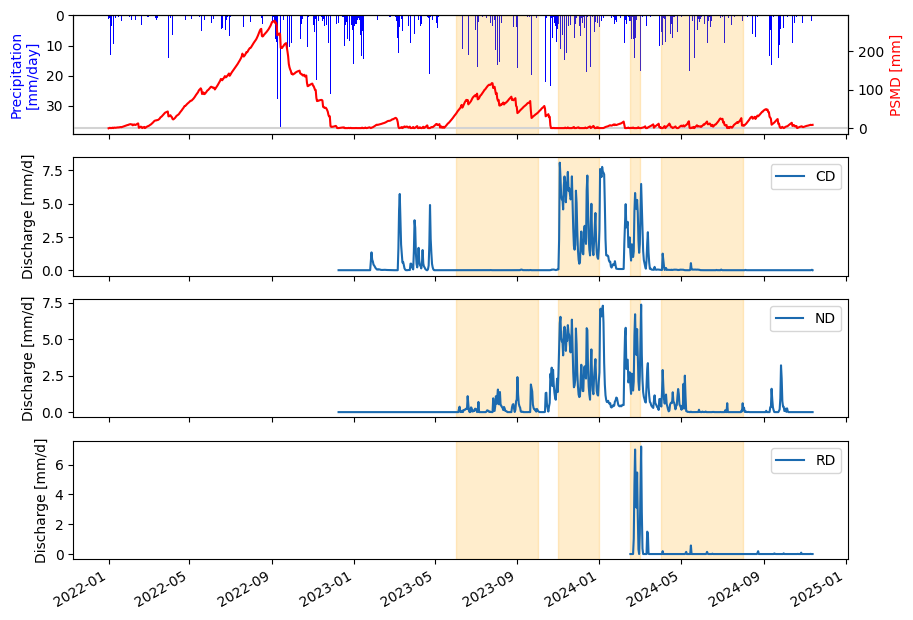

In [6]:
# time series
periods = {
    'summer2023': [pd.to_datetime('2023-06-01'), pd.to_datetime('2023-10-01')],
    'winter2023cdnd': [pd.to_datetime('2023-11-01'), pd.to_datetime('2024-01-01')],
    'winter2023all': [pd.to_datetime('2024-02-15'), pd.to_datetime('2024-03-01')],
    'summer2024': [pd.to_datetime('2024-04-01'), pd.to_datetime('2024-08-01')],
}

areadic = {
    'CD': 30000,
    'RD': 18000,
    'ND': 3875,
}
fig, axs = plt.subplots(4, 1, figsize=(10, 8), sharex=True)
ax = axs[0]
ax.bar(dfweather['time'], dfweather['PRECIP_QUANTITY'], color='b')
ax.invert_yaxis()
ax.set_ylabel('Precipitation\n[mm/day]', color='blue')
ax2 = ax.twinx()
ax2.axhline(0, color='lightgrey')
ax2.plot(dfweather['time'], dfweather['psmd'], 'r-')
ax2.set_ylabel('PSMD [mm]', color='red')
for j, key in enumerate(periods):
    ax.axvspan(*periods[key], alpha=0.2, color='orange')

for i, name in enumerate(dfdrain['name'].unique()):
    ax = axs[i+1]
    # ie = dfdrain['name'].eq(name)
    # ax.plot(dfdrain[ie]['time'], dfdrain[ie]['Debiet'], '-', label=name)
    # ax.legend(loc=2)
    # ax.set_ylabel('Discharge [m$^3$/h]')

    ie = dfdrain['name'].eq(name)
    df = dfdrain[ie].copy()
    df['dt'] = df['time'].diff().dt.seconds/3600  # fractional hours
    df['q'] = df['Debiet'] * df['dt']
    df['q_mm'] = df['q'] / areadic[name] * 1000
    df = df.set_index('time').resample('D').sum().reset_index()
    ax.plot(df['time'], df['q_mm'], '-', label=name)
    ax.set_ylabel('Discharge [mm/d]')
    ax.legend()

    for j, key in enumerate(periods):
        ax.axvspan(*periods[key], alpha=0.2, color='orange')
fig.autofmt_xdate()

We can see that we need a bit of water to "refill" the field in CD before it starts to drain like RD during 2024 winter.

In [7]:
# for each period we compare the sum of drainage with the sum of water
areadic = {
    'CD': 30000,
    'RD': 18000,
    #'ND': 3550, # adjusted for winter2023cdnd
    #'ND': 4200,  # adjusted for winter2023all
    'ND': 3875,  # average
}
# ajdust area of RD and ND until ewe have the same q_mm between CD and ND during winter periods

data = []
for key in periods:
    idate = dfdrain['time'].between(*periods[key])
    iweather = dfweather['time'].between(*periods[key])
    rain = dfweather[iweather]['PRECIP_QUANTITY'].sum()
    for name in dfdrain['name'].unique():
        ie = dfdrain['name'].eq(name) & idate
        df = dfdrain[ie].copy()
        df['dt'] = df['time'].diff().dt.seconds/3600  # fractional hours
        df['q'] = df['Debiet'] * df['dt']  # m3 for time between readings
        data.append({
            'period': key,
            'name': name,
            'drainage_m3': df['q'].sum(),
            'rain_mm': rain,
            'q_mm': df['q'].sum() / areadic[name] * 1000,
        })
pd.DataFrame(data)

,period,name,drainage_m3,rain_mm,q_mm
0,summer2023,CD,8.859553,273.2,0.295318
1,summer2023,ND,125.380583,273.2,32.356280
2,summer2023,RD,0.000000,273.2,0.000000
3,winter2023cdnd,CD,6700.773519,334.4,223.359117
4,winter2023cdnd,ND,798.168075,334.4,205.978858
5,winter2023cdnd,RD,0.000000,334.4,0.000000
6,winter2023all,CD,1309.307036,72.8,43.643568
7,winter2023all,ND,185.812533,72.8,47.951622
8,winter2023all,RD,509.754983,72.8,28.319721
9,summer2024,CD,139.537356,307.1,4.651245


## Where does the water go?
Analysis of fluxes (rainfall, evapotranspiration, drainage and infiltration).

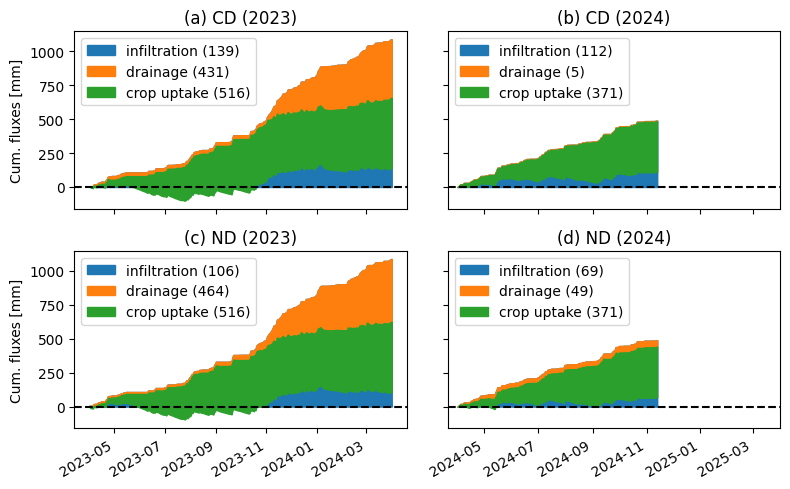

In [8]:
def plot_fluxes(name, year, ax, legend=True):
    areadic = {
        'CD': 30000,
        'RD': 18000,
        'ND': 3875,  # average
    }
    df = dfweather.copy()
    df2 = dfdrain[dfdrain['name'].eq(name)].set_index('time')\
        .groupby(pd.Grouper(freq='d')).first().ffill().reset_index()
    df = pd.merge(df, df2, on='time')
    if year == 2023:
        df = df[df['time'].between(pd.to_datetime('2023-04-01'), pd.to_datetime('2024-04-01'))]
    elif year == 2024:
        df = df[df['time'].between(pd.to_datetime('2024-04-01'), pd.to_datetime('2025-04-01'))]
    df = df.reset_index(drop=True)
    
    # in 2023, ND discharge was not installed before 1st May as such, we
    # also add the CD discharge measured to ND
    if year == 2023 and name == 'ND':
        iq = dfdrain['name'].eq('CD') & dfdrain['time'].gt('2023-05-01')
        offset = dfdrain[iq]['TotaalDebiet'].values[0]/areadic['CD']*1000
        #print('offset', offset, 'mm')
        df['TotaalDebiet'] = df['TotaalDebiet'] + offset
        df.loc[0, 'TotaalDebiet'] = 0  # to avoid to subtract the offset in next line
    
    # divided by surface in m^3 then converted to m
    df['q_mm_cum'] = (df['TotaalDebiet'] - df['TotaalDebiet'].dropna().values[0])/areadic[name]*1000
    
    # no ET after october (depends on the crop really)
    df.loc[df['time'].dt.month.gt(10), 'eto'] = 0  # assume no et0 after october

    # fig, ax = plt.subplots()
    # ax.plot(df['time'], df['eto'].cumsum())
    # ax.plot(df['time'], df['PRECIP_QUANTITY'].cumsum())
    # ax.plot(df['time'], df['q_mm_cum'])
    # ax.set_ylabel('Rainfall [mm]')
    # fig.autofmt_xdate()
    
    y1 = df['PRECIP_QUANTITY'].cumsum()
    y2 = df['PRECIP_QUANTITY'].cumsum() - df['q_mm_cum']
    y3 = df['PRECIP_QUANTITY'].cumsum() - df['q_mm_cum'] - df['eto'].cumsum()
    
    ax.set_title('{:s} ({:d})'.format(name,  year))
    ax.fill_between(df['time'], 0, y1, color='tab:blue',
                    label='infiltration ({:.0f})'.format(y3.values[-1]))
    ax.fill_between(df['time'], y1, y2, color='tab:orange',
                    label='drainage ({:.0f})'.format(df['q_mm_cum'].values[-1]))
    ax.fill_between(df['time'], y2, y3, color='tab:green',
                    label='crop uptake ({:.0f})'.format(df['eto'].cumsum().values[-1]))
    ax.axhline(0, color='k', linestyle='--')
    if legend:
        ax.legend(loc=2)
    ax.set_ylabel('Cum. fluxes [mm]')

fig, axs = plt.subplots(2, 2, figsize=(8, 5), sharey=True, sharex='col')
# axs[0, 0].remove()
# ax = axs[0, 1]
# plot_fluxes('RD', 2024, ax=ax)
ax = axs[0, 0]
plot_fluxes('CD', 2023, ax=ax)
ax = axs[0, 1]
plot_fluxes('CD', 2024, ax=ax)
ax.set_ylabel('')
ax = axs[1, 0]
plot_fluxes('ND', 2023, ax=ax)
ax = axs[1, 1]
plot_fluxes('ND', 2024, ax=ax)
ax.set_ylabel('')
for i, ax in enumerate(axs.flatten()):
    ax.set_title('({:s}) {:s}'.format(letters[i], ax.get_title()))
ax.set_xlim([None, pd.to_datetime('2025-04-01')])
fig.autofmt_xdate()
fig.tight_layout()
fig.savefig(figdir + 'fluxes.jpg', dpi=300)

## How ERT relate to soil layering?

2024-10-09 00:00:00
2024-10-09 00:00:00
2024-10-09 00:00:00
2024-10-09 00:00:00
2024-10-09 00:00:00
2024-10-09 00:00:00
2024-10-09 00:00:00
2024-10-09 00:00:00
2024-10-09 00:00:00


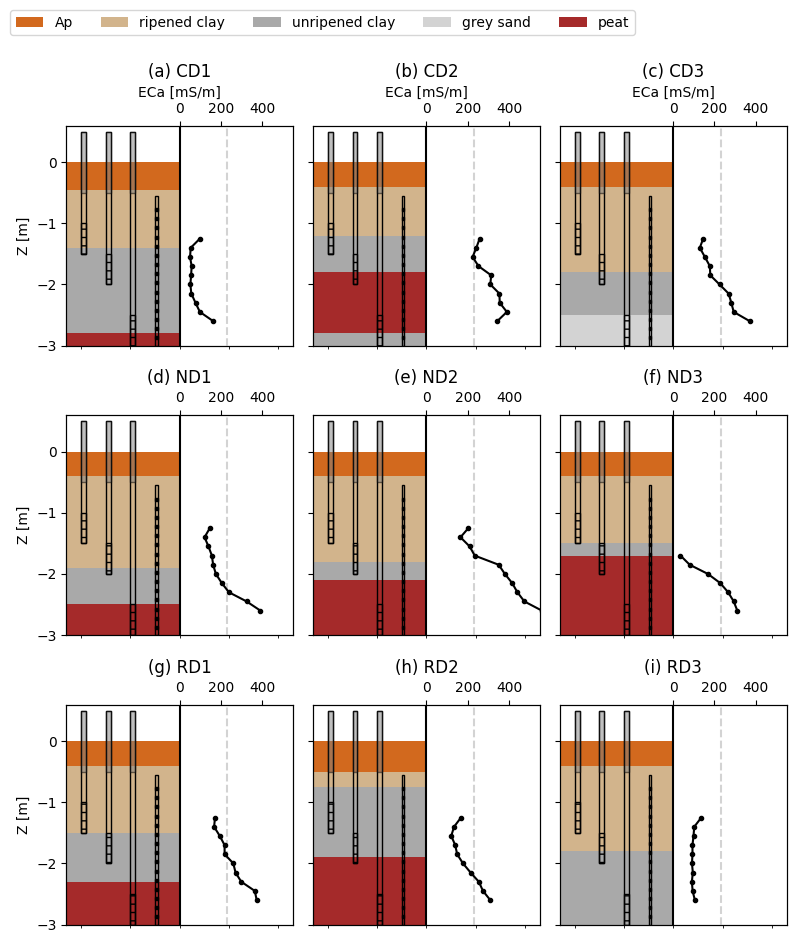

In [9]:
from matplotlib.patches import Rectangle

cdic = {
    'Ap': 'chocolate',
    'ripened clay': 'tan',
    'unripened clay': 'darkgrey',
    'grey sand': 'lightgrey',
    'peat': 'brown',
}


def addPiezo(ax, z0=0):
    # piezo buried part
    ax.annotate('piezometer', (1.5, z0+0.7), ha='center')
    ax.add_patch(Rectangle((2, z0-3), 0.1, 3.5, edgecolor='k', facecolor='none'))
    ax.add_patch(Rectangle((1.5, z0-2), 0.1, 2.5, edgecolor='k', facecolor='none'))
    ax.add_patch(Rectangle((1, z0-1.5), 0.1, 2, edgecolor='k', facecolor='none'))

    # piezo removable part
    ax.add_patch(Rectangle((2, z0-0.5), 0.1, 1, edgecolor='k', facecolor='grey', alpha=0.5))
    ax.add_patch(Rectangle((1.5, z0-0.5), 0.1, 1, edgecolor='k', facecolor='grey', alpha=0.5))
    ax.add_patch(Rectangle((1, z0-0.5), 0.1, 1, edgecolor='k', facecolor='grey', alpha=0.5))

    # piezo screens
    ax.add_patch(Rectangle((2, z0-3), 0.1, 0.5, edgecolor='k', facecolor='none', hatch='--'))
    ax.add_patch(Rectangle((1.5, z0-2), 0.1, 0.5, edgecolor='k', facecolor='none', hatch='--'))
    ax.add_patch(Rectangle((1, z0-1.5), 0.1, 0.5, edgecolor='k', facecolor='none', hatch='--'))    

def addStick(ax, z0=0):
    # ERT
    ax.annotate('ERT', (2.5, z0+0.7), ha='center')
    ax.add_patch(Rectangle((2.5, z0-3.05), 0.05, 2.5, edgecolor='k', facecolor='none'))
    #ax.add_patch(Rectangle((3, -0.5), 0.05, 0.5, facecolor='grey', alpha=0.5))
    for i in range(17):
        ax.add_patch(Rectangle((2.5, z0-0.8-i*0.15), 0.05, 0.05, color='k'))

fig, axs = plt.subplots(3, 3, figsize=(8, 9), sharex=True, sharey=True)
axs = axs.flatten()
for i, name in enumerate(sorted(dfsoil['name'].unique())):
    ax = axs[i]
    ax.set_title('({:s}) {:s}'.format(letters[i], name.split('-')[0]))
    ie = dfsoil['name'].eq(name)
    df = - dfsoil[ie][['thickness_m', 'layer']].set_index('layer').T
    #elev = dfpiezo[dfpiezo['name'].eq(piezo)]['elevation surface RTK'].values[0]
    elev = 0 # do not consider elevation
    df.plot.bar(ax=ax, stacked=True, color=[cdic[a] for a in df.columns],
                width=6, bottom=elev)
    addPiezo(ax, z0=elev)
    addStick(ax, z0=elev)
    ax.get_legend().remove()

    # adding ECa
    ax2 = ax.twiny()
    ax2.axvline(230, color='lightgrey', linestyle='--')
    sdate = dfeca['time'].unique()[-3]
    print(sdate)
    ie = (dfeca['name'].eq(name.split('-')[0]) & 
            dfeca['time'].eq(sdate) & # time chosen
            (dfeca['a'] - dfeca['m']).eq(-2))  # first or second quad level
    df = dfeca[ie][['zpos', 'eca']].groupby('zpos').mean().reset_index()
    ax2.plot(df['eca'], df['zpos'], 'k.-')
    if i < 3:
        ax2.set_xlabel('ECa [mS/m]')
    ax2.set_xlim([-550, 550])
    ax2.axvline(0, color='k')
    #ax2.axvline(250, color='lightgrey')
    xticks = np.arange(0, 500, 200)
    ax2.set_xticks(xticks)
    ax2.set_xticklabels(xticks)

    
ax.set_ylim([0.6, -3])
ax.set_xlim([0.7, 5.3])
axs[0].set_ylabel('Z [m]')
axs[3].set_ylabel('Z [m]')
axs[6].set_ylabel('Z [m]')

# build legend
markers = []
for key in cdic:
    markers.append(ax.add_patch(Rectangle((0, 0), 0, 0, facecolor=cdic[key], label=key)))
fig.legend(handles=markers, bbox_to_anchor=(0.8, 1.05), ncol=5)
ax.invert_yaxis()
fig.tight_layout()
fig.savefig(figdir + 'lithology-eca.jpg', dpi=300)

## Difference in ECa

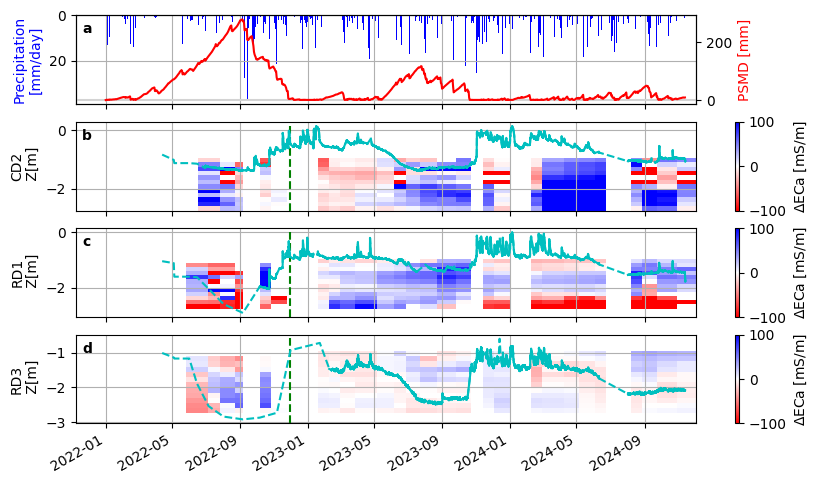

In [10]:
names = ['CD2', 'RD1', 'RD3']
# names = ['CD2', 'RD2', 'ND2']
# names = ['CD1', 'CD2', 'CD3', 'RD1', 'RD2', 'RD3', 'ND1', 'ND2', 'ND3']
fig, axs = plt.subplots(len(names)+1, 1, figsize=(10, len(names)*2),
                        sharex=True)
[ax.grid() for ax in axs]

# weather
ax = axs[0]
ax.annotate('a', (0.01, 0.8), xycoords='axes fraction', weight='bold')
ax.bar(dfweather['time'], dfweather['PRECIP_QUANTITY'], color='b')
ax.invert_yaxis()
ax.set_ylabel('Precipitation\n[mm/day]', color='blue')
ax2 = ax.twinx()
ax2.axhline(0, color='lightgrey')
ax2.plot(dfweather['time'], dfweather['psmd'], 'r-')
ax2.set_ylabel('PSMD [mm]', color='red')

# stick difference
for i, name in enumerate(names):
    ax = axs[i+1]
    ax.annotate(letters[i+1], (0.01, 0.8), xycoords='axes fraction', weight='bold')
    ax.set_ylabel(name + '\n Z[m]')
    ie = (dfeca['name'].eq(name.split('-')[0]) & 
        (dfeca['a'] - dfeca['m']).eq(-1))  # first or second quad level
    df = dfeca[ie][['time', 'zpos', 'eca']].groupby(['time', 'zpos']).mean().reset_index()
    df = df.pivot(columns=['time'], index=['zpos'], values=['eca'])
    df = df.sort_index(ascending=False)
    df.columns = [a[1] for a in df.columns]
    
    xdates = df.columns.values
    zpos = df.index.values
    ydiff = np.diff(zpos)
    y = np.r_[zpos[0]-ydiff[0]/2, zpos[:-1]-ydiff/2, zpos[-1]-ydiff[-1]/2]
    iref = 6  # reference date
    if 'CD' in name:
        iref = 5
    # iref = 0  # first survey
    ax.axvline(xdates[iref], color='green', linestyle='--')
    # vals = df.values
    vals = (df.values-df.values[:, iref][:, None])#/df.values[:, iref][:, None]*100
    # vals = df.diff(axis=1).values
    X2, Y2, Z2 = addGap(xdates, y, vals, pad=0, dt=np.timedelta64(40, 'D'))
    cax = ax.pcolormesh(X2, Y2, Z2, cmap='bwr_r', vmin=-100, vmax=100)
    X3, Y3 = np.meshgrid(X2[0, :-1] + np.diff(X2[0, :]),
                         Y2[:-1, 0] + np.diff(Y2[:, 0]))
    # ax.contour(X3, Y3, Z2, levels=[20], cmap=plt.cm.Greens_r)
    fig.colorbar(cax, ax=ax, label=r'$\Delta$ECa [mS/m]')

    # add water table
    iem = dfhead['name'].eq(name + '-300')
    ie = dfobs['name'].eq(name + '-300')
    varname = 'head_surf'  # not fresh head is what the ERT sees
    #ie = ie & ((dfobs[varname] - dfobs[ie][varname].mean()).abs() < dfobs[ie][varname].std()*2)

    # merged manual and sensor data
    x, y = mergeManualAuto(dfobs[ie]['time'].values,
                           dfobs[ie][varname].values,
                           dfhead[iem]['time'].values,
                           dfhead[iem][varname].values)
    ax.plot(x, -y, 'c--')
    ax.plot(dfobs[ie]['time'].values, -dfobs[ie][varname].values, 'c-')
    # NOTE: uncorrected head but that's what the ERT sees

fig.autofmt_xdate()

# realign the first axis
pos = ax.get_position().bounds
pos0 = axs[0].get_position().bounds
pos0 = (pos0[0], pos0[1], pos[2], pos0[3])
axs[0].set_position(pos0)
fig.savefig(figdir + 'diff-eca.jpg', dpi=300)

## How are things evolving?

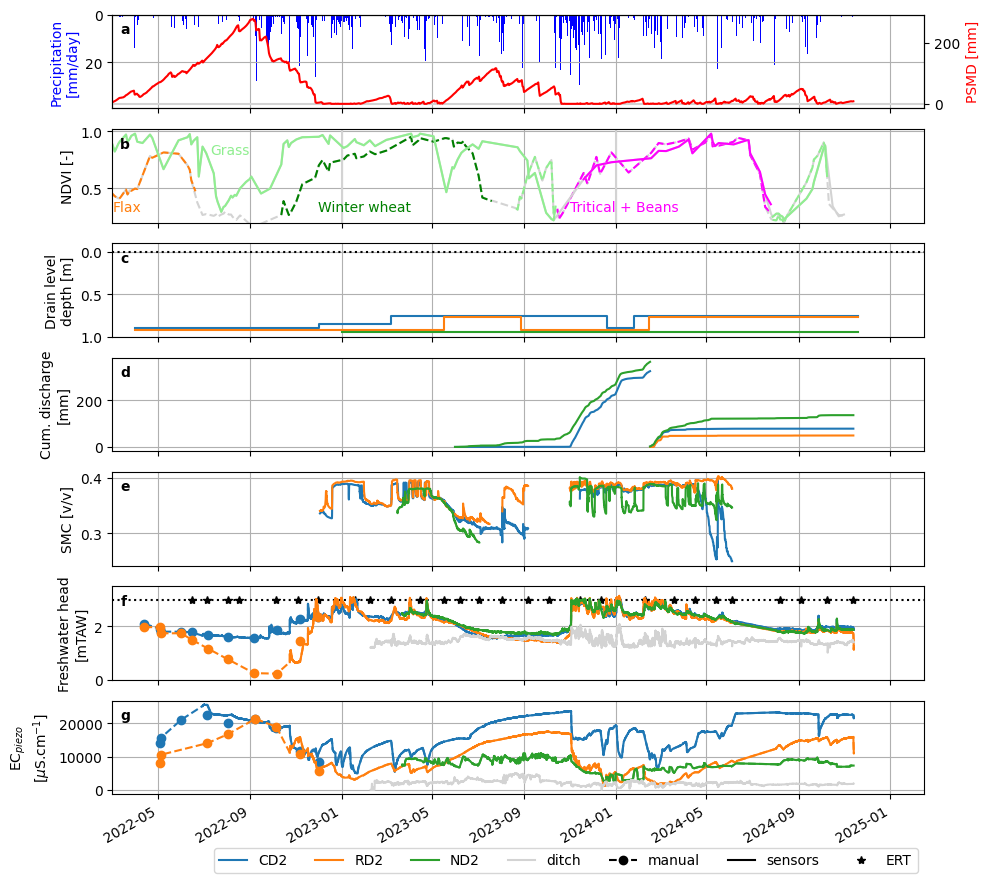

In [11]:
fig, axs = plt.subplots(7, 1, figsize=(10, 10), sharex=True)
[ax.grid() for ax in axs]
cdic = {
    'CD2': 'tab:blue',
    'RD2': 'tab:orange',
    'ND2': 'tab:green',
}
names = cdic.keys()

# weather
ax = axs[0]
ax.annotate('a', (0.01, 0.8), xycoords='axes fraction', weight='bold')
ax.bar(dfweather['time'], dfweather['PRECIP_QUANTITY'], color='b')
ax.invert_yaxis()
ax.set_ylabel('Precipitation\n[mm/day]', color='blue')
ax2 = ax.twinx()
ax2.axhline(0, color='lightgrey')
ax2.plot(dfweather['time'], dfweather['psmd'], 'r-')
ax2.set_ylabel('PSMD [mm]', color='red')

# crops
ax = axs[1]
ax.annotate('b', (0.01, 0.8), xycoords='axes fraction', weight='bold')
# evolution of NDVI throughout the season
cropdic = {
    'Flax': 'tab:orange',
    'Winter flax': 'tab:orange',
    'Winter wheat': 'green',
    'Grass': 'lightgreen',
    'Winter wheat + beans': 'lime',
    'Triticale + Beans': 'magenta',
}

for i in range(5):
    ax.axvline(pd.to_datetime('{:d}-01-01'.format(2020 + i)), color='lightgrey')
for linestyle, name, label in zip(['--', '-'], ['CD2', 'RD2'], ['CD & ND', 'RD']):
    ie = dfndvi['field'].eq(name[:2].lower())
    ax.plot(dfndvi[ie]['time'], dfndvi[ie]['median'], 'lightgrey',
            linestyle=linestyle, label=label)
    df1 = dfndvi[ie][['time', 'median']].copy()
    shdates = dfcrop[dfcrop['name'].eq(name) 
                & dfcrop['event'].isin(['sowing', 'harvest'])]['time'].values
    df2 = pd.DataFrame({'time': shdates})
    df = pd.concat([df1, df2]).sort_values('time').interpolate()
    ie = dfcrop['name'].eq(name)
    sdf = dfcrop[ie].copy().reset_index(drop=True)
    # first add the crops
    crops = []
    for j in range(sdf.shape[0]):
        if sdf.loc[j, 'event'] == 'sowing':
            sowingDate = sdf.loc[j, 'time']
        elif sdf.loc[j, 'event'] == 'harvest':
            harvestDate = sdf.loc[j, 'time']
            label = sdf.loc[j, 'crop'] if sdf.loc[j, 'crop'] not in crops else None
    
            icrop = df['time'].gt(sowingDate) & df['time'].le(harvestDate)
            ax.plot(df[icrop]['time'], df[icrop]['median'], linestyle=linestyle,
                            color=cropdic[sdf.loc[j, 'crop']])
ax.text(pd.to_datetime('2022-03-01'), 0.3, 'Flax', color='tab:orange')
ax.text(pd.to_datetime('2022-07-10'), 0.8, 'Grass', color='lightgreen')
ax.text(pd.to_datetime('2022-12-01'), 0.3, 'Winter wheat', color='green')
ax.text(pd.to_datetime('2023-11-01'), 0.3, 'Tritical + Beans', color='magenta')
# ax.annotate('grass cut', (pd.to_datetime('2023-06-01'), 0.5))
# ax.annotate('grass cover crop', (pd.to_datetime('2024-08-01'), 0.5))

ax.set_ylim([0.2, None])
ax.set_ylabel('NDVI [-]')

# level
ax = axs[2]
ax.annotate('c', (0.01, 0.8), xycoords='axes fraction', weight='bold')
ax.set_ylabel('Drain level\ndepth [m]')
ax.axhline(0, color='k', linestyle=':')
for i, name in enumerate(names):
    ie = dflevel['field'].eq(name[:-1])
    ax.plot(dflevel[ie]['time'], 0.9 - dflevel[ie]['pipe_height'] + i*0.02, '-',
            color=cdic[name])
ax.set_ylim([1, -0.1])
#ax.invert_yaxis()

# drainage
ax = axs[3]
ax.annotate('d', (0.01, 0.8), xycoords='axes fraction', weight='bold')
areadic = {
    'CD': 30000,
    'RD': 18000,
    'ND': 3875,
}
periods = [pd.to_datetime('2022-01-01'), pd.to_datetime('2023-01-01'),
           pd.to_datetime('2024-02-16'), pd.to_datetime('2025-01-01')]

for i, name in enumerate(names):
    ie = dfdrain['name'].eq(name[:-1]) & dfdrain['time'].gt(pd.to_datetime('2023-06-01'))
    df = dfdrain[ie].copy()
    df['dt'] = df['time'].diff().dt.seconds/3600  # fractional hours
    df['q'] = df['Debiet'] * df['dt']  # we have m3 or the time between two readings
    df['q_mm'] = df['q'] / areadic[name[:-1]] * 1000  # mm for the time betwee readings
    df = df.set_index('time').resample('D').sum().reset_index()
    for j in range(len(periods) - 1):
        ie = df['time'].between(periods[j], periods[j+1])
        ax.plot(df[ie]['time'], df[ie]['q_mm'].cumsum(), '-', label=name, color=cdic[name])
ax.set_ylabel('Cum. discharge\n[mm]')

# soil moisture
ax = axs[4]
ax.annotate('e', (0.01, 0.8), xycoords='axes fraction', weight='bold')
for name in names:
    ie = dfvwc['name'].eq(name) & dfvwc['depth'].eq(0.30)
    ax.plot(dfvwc[ie]['time'], dfvwc[ie]['vwc'], color=cdic[name], label=name)
ax.set_ylabel('SMC [v/v]')

# water table
ax = axs[5]
ax.annotate('f', (0.01, 0.8), xycoords='axes fraction', weight='bold')
ax.axhline(3, color='k', linestyle=':')
xdates = dfeca['time'].unique()
ax.plot(xdates, [3]*len(xdates), 'k*', label='ERT')
for name in names:
    iem = dfhead['name'].eq(name + '-300') & dfhead['time'].lt(pd.to_datetime('2023-01-01'))
    ie = dfobs['name'].eq(name + '-300')
    varname = 'head_fresh_mtaw'
    ie = ie & ((dfobs[varname] - dfobs[ie][varname].mean()).abs() < dfobs[ie][varname].std()*3)

    # merged manual and sensor data
    x, y = mergeManualAuto(dfobs[ie]['time'].values,
                           dfobs[ie][varname].values,
                           dfhead[iem]['time'].values,
                           dfhead[iem]['head_mTAW'].values)
    cax = ax.plot(x, y, '--', color=cdic[name])
    ax.plot(dfobs[ie]['time'].values, dfobs[ie][varname].values,
            '-', color=cax[0].get_color())

    # manual data
    ax.plot(dfhead[iem]['time'].values,
            dfhead[iem]['head_mTAW'].values, marker='o', linestyle='none',
            color=cax[0].get_color())
iditch = dfditch['name'].eq('ditchRD')
ax.plot(dfditch[iditch]['time'], dfditch[iditch]['head_fresh_mtaw'], '-',
        color='lightgrey', label='ditch')
ax.set_ylabel('Freshwater head\n[mTAW]')
ax.set_ylim([0, 3.5])


# salinity/ECw
ax = axs[6]
ax.annotate('g', (0.01, 0.8), xycoords='axes fraction', weight='bold')
for name in names:
    iem = dfec['name'].eq(name + '-300') & dfec['time'].lt(pd.to_datetime('2023-01-01'))
    ie = dfobs['name'].eq(name + '-300')
    varname = 'electrical_conductivity'
    ie = ie & ((dfobs[varname] - dfobs[ie][varname].mean()).abs() < dfobs[ie][varname].std()*3)

    # merged manual and sensor data
    x, y = mergeManualAuto(dfobs[ie]['time'].values,
                           dfobs[ie][varname].values,
                           dfec[iem]['time'].values,
                           dfec[iem]['EC_uS.cm-1'].values)
    cax = ax.plot(x, y, '--', color=cdic[name])
    ax.plot(dfobs[ie]['time'].values, dfobs[ie][varname].values,
            '-', color=cax[0].get_color(), label=name)

    # manual
    ax.plot(dfec[iem]['time'], dfec[iem]['EC_uS.cm-1'],
            marker='o', linestyle='none', color=cax[0].get_color())
ax.plot(dfditch[iditch]['time'], dfditch[iditch]['electrical_conductivity'],
        '-', color='lightgrey', label='ditch')
ax.plot([], [], 'ko--', label='manual')
ax.plot([], [], 'k-', label='sensors')
ax.plot([], [], 'k*', label='ERT')
ax.set_ylabel(r'EC$_{piezo}$' + '\n' + r'[$\mu$S.cm$^{-1}$]')
ax.legend(ncol=7, bbox_to_anchor=(1, -0.5))

ax.set_xlim([pd.to_datetime('2022-03-01'), None])
fig.tight_layout()
fig.autofmt_xdate()
fig.savefig(figdir + 'evolution-selected.jpg', dpi=300)

## How the fresh water evolves?

RD1 forward filling 1 NaN
RD3 forward filling 28 NaN


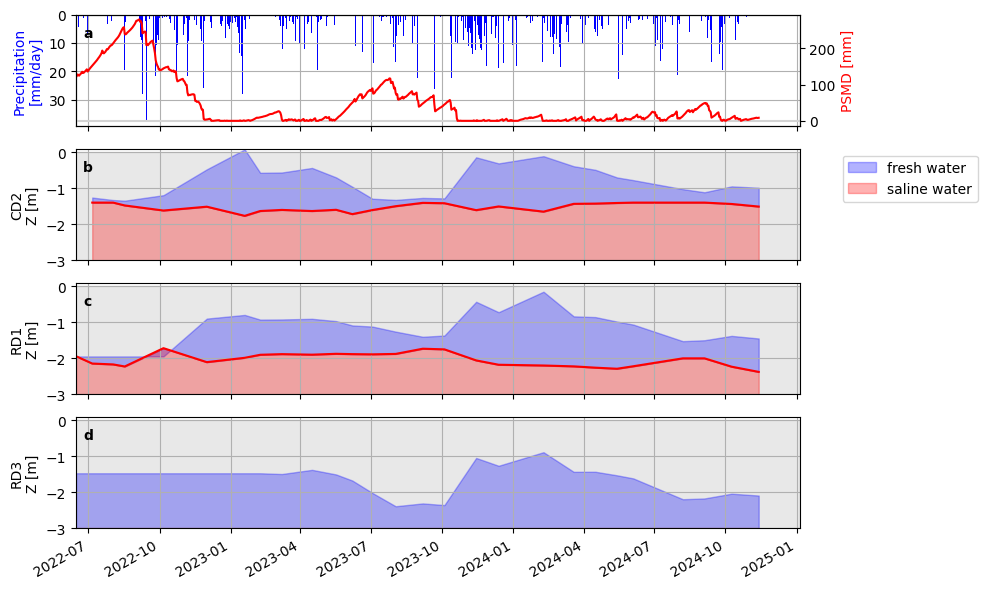

In [12]:
names = ['CD2', 'RD1', 'RD3']
# names = ['CD2', 'RD2', 'ND2']
# names = ['CD1', 'CD2', 'CD3', 'RD1', 'RD2', 'RD3', 'ND1', 'ND2', 'ND3']
fig, axs = plt.subplots(len(names)+1, 1, figsize=(10, len(names)*2),
                        sharex=True)
[ax.grid() for ax in axs]

# weather
ax = axs[0]
ax.annotate('a', (0.01, 0.8), xycoords='axes fraction', weight='bold')
ax.bar(dfweather['time'], dfweather['PRECIP_QUANTITY'], color='b')
ax.invert_yaxis()
ax.set_ylabel('Precipitation\n[mm/day]', color='blue')
ax2 = ax.twinx()
ax2.axhline(0, color='lightgrey')
ax2.plot(dfweather['time'], dfweather['psmd'], 'r-')
ax2.set_ylabel('PSMD [mm]', color='red')

# zout water lens
for i, name in enumerate(names):
    ax = axs[i+1]
    ax.annotate(letters[i+1], (0.01, 0.8), xycoords='axes fraction', weight='bold')
    ax.set_ylabel(name + '\nZ [m]')
    ie = dfthresh['name'].eq(name)
    dates = dfthresh[ie]['time']
    s = dfthresh[ie]['threshdepths']
    if s.isna().sum() > 0:
        print(name, 'forward filling {:d} NaN'.format(s.isna().sum()))
        if s.isna().sum() > 10: # sandy ones
            s = pd.Series([-3.5]*len(s))  # saline water depth is at least -3.5 m below surface
        else:
            s = s.ffill()
    thresholds = s.values
    
    # get water table for ERT date
    wts = []
    iloc = dfobs['name'].eq(name + '-300') & dfobs['head_surf'].notnull()
    for date in dates:
        wdate = pd.to_datetime(date)
        idate = np.argmin((dfobs[iloc]['time'] - wdate).abs().values)
        wt = dfobs[iloc]['head_surf'].values[idate]  # uncorrected head is what the ERT sees
        wts.append(wt)
    wts = np.array(wts)

    # lines for checking the figure is correct
    # ax.plot(dfobs[iloc]['time'], -dfobs[iloc]['head_surf'], 'b-')
    # ax.plot(dates, -wts, 'b')
    # ax.plot(dates, thresholds, 'r')

    # plot shades representing fresh and saline water
    ax.plot(dates, thresholds, color='r')
    ax.axhspan(-3, 0, color='lightgrey', alpha=0.5)
    ie = (thresholds + wts) > 0  # capillary rise of salinity
    # ax.fill_between(dates[~ie], thresholds[~ie], -wts[~ie],
    #                 color='blue', alpha=0.3, label='fresh water')
    ax.fill_between(dates, thresholds, -wts,
                    color='blue', alpha=0.3, label='fresh water')
    ax.fill_between(dates, -3, thresholds,
                    color='red', alpha=0.3, label='saline water')
    if i == 0:
        ax.legend(bbox_to_anchor=(1.05, 1))
ax.set_xlim([dfthresh['time'].min(), None])
[ax.set_ylim([-3, 0.1]) for ax in axs[1:]]
fig.autofmt_xdate()
fig.tight_layout()
fig.savefig(figdir + 'freshwater-lens-ert.jpg', dpi=300)

## Effect of sandy channel in RD?

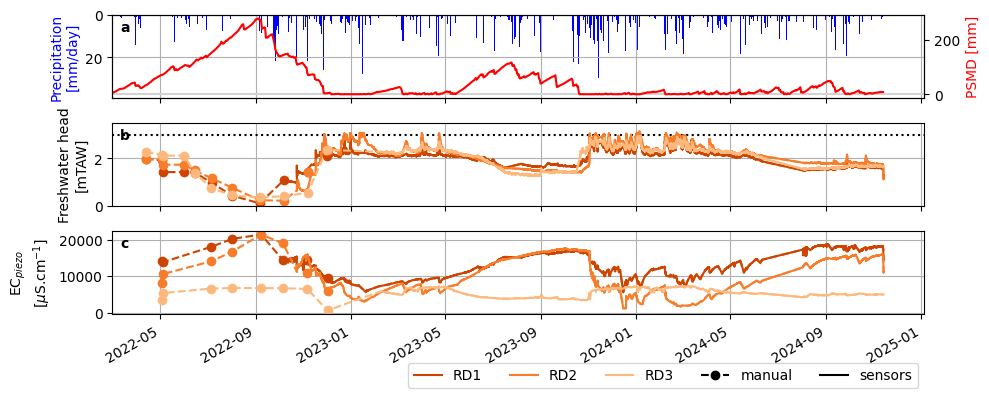

In [13]:
# focus on the sandy channel behaviour
fig, axs = plt.subplots(3, 1, figsize=(10, 4), sharex=True)
[ax.grid() for ax in axs]
cdic = {
    'RD1': plt.get_cmap('Oranges', 10)(7),
    'RD2': plt.get_cmap('Oranges', 10)(5),
    'RD3': plt.get_cmap('Oranges', 10)(3),
}
names = cdic.keys()

# weather
ax = axs[0]
ax.annotate('a', (0.01, 0.8), xycoords='axes fraction', weight='bold')
ax.bar(dfweather['time'], dfweather['PRECIP_QUANTITY'], color='b')
ax.invert_yaxis()
ax.set_ylabel('Precipitation\n[mm/day]', color='blue')
ax2 = ax.twinx()
ax2.axhline(0, color='lightgrey')
ax2.plot(dfweather['time'], dfweather['psmd'], 'r-')
ax2.set_ylabel('PSMD [mm]', color='red')

# soil moisture
# ax = axs[1]
# ax.annotate('b', (0.01, 0.8), xycoords='axes fraction', weight='bold')
# for name in names:
#     ie = dfvwc['name'].eq(name) & dfvwc['depth'].eq(0.30)
#     ax.plot(dfvwc[ie]['time'], dfvwc[ie]['vwc'], color=cdic[name], label=name)
# ax.set_ylabel('SMC [v/v]')

# water table
ax = axs[1]
ax.annotate('b', (0.01, 0.8), xycoords='axes fraction', weight='bold')
ax.axhline(3, color='k', linestyle=':')
for name in names:
    iem = dfhead['name'].eq(name + '-300') & dfhead['time'].lt(pd.to_datetime('2023-01-01'))
    ie = dfobs['name'].eq(name + '-300')
    varname = 'head_fresh_mtaw'
    ie = ie & ((dfobs[varname] - dfobs[ie][varname].mean()).abs() < dfobs[ie][varname].std()*3)

    # merged manual and sensor data
    x, y = mergeManualAuto(dfobs[ie]['time'].values,
                           dfobs[ie][varname].values,
                           dfhead[iem]['time'].values,
                           dfhead[iem]['head_mTAW'].values)
    cax = ax.plot(x, y, '--', color=cdic[name])
    ax.plot(dfobs[ie]['time'].values, dfobs[ie][varname].values,
            '-', color=cax[0].get_color())

    # manual data
    ax.plot(dfhead[iem]['time'].values,
            dfhead[iem]['head_mTAW'].values, marker='o', linestyle='none',
            color=cax[0].get_color())
# iditch = dfditch['name'].eq('ditchRD')
# ax.plot(dfditch[iditch]['time'], dfditch[iditch]['head_fresh_mtaw'], '-',
#         color='lightgrey', label='ditch')
ax.set_ylabel('Freshwater head\n[mTAW]')
ax.set_ylim([0, 3.5])


# salinity/ECw
ax = axs[2]
ax.annotate('c', (0.01, 0.8), xycoords='axes fraction', weight='bold')
for name in names:
    iem = dfec['name'].eq(name + '-300') & dfec['time'].lt(pd.to_datetime('2023-01-01'))
    ie = dfobs['name'].eq(name + '-300')
    varname = 'electrical_conductivity'
    ie = ie & ((dfobs[varname] - dfobs[ie][varname].mean()).abs() < dfobs[ie][varname].std()*3)

    # merged manual and sensor data
    x, y = mergeManualAuto(dfobs[ie]['time'].values,
                           dfobs[ie][varname].values,
                           dfec[iem]['time'].values,
                           dfec[iem]['EC_uS.cm-1'].values)
    cax = ax.plot(x, y, '--', color=cdic[name])
    ax.plot(dfobs[ie]['time'].values, dfobs[ie][varname].values,
            '-', color=cax[0].get_color(), label=name)

    # manual
    ax.plot(dfec[iem]['time'], dfec[iem]['EC_uS.cm-1'],
            marker='o', linestyle='none', color=cax[0].get_color())
# ax.plot(dfditch[iditch]['time'], dfditch[iditch]['electrical_conductivity'],
#         '-', color='lightgrey', label='ditch')
ax.plot([], [], 'ko--', label='manual')
ax.plot([], [], 'k-', label='sensors')
ax.set_ylabel(r'EC$_{piezo}$' + '\n' + r'[$\mu$S.cm$^{-1}$]')
ax.legend(ncol=7, bbox_to_anchor=(1, -0.5))

ax.set_xlim([pd.to_datetime('2022-03-01'), None])
fig.tight_layout()
fig.autofmt_xdate()
fig.savefig(figdir + 'evolution-rd.jpg', dpi=300)